# Sequential Graphs

## Introduction

This notebook demonstrates how to build sequential graphs for chatbot workflows using LangGraph and LangChain.

## Environment Setup

In [1]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from dotenv import load_dotenv
from rich import print
from IPython.display import Image, display
# Load environment variables from .env file
load_dotenv('../.env')

True

## Basic Chatbot Example

In [2]:
llm = ChatOllama(model="llama3.2")
llm.invoke("Hello, world!").content

"Hello! It's nice to meet you. Is there something I can help you with or would you like to chat?"

### Agent State Definition

In [3]:
class AgentState(TypedDict):
    name: str
    age: str
    final: str
    message: str

### Node Functions

In [4]:
def greating_message(state: AgentState) -> AgentState:
    """Function to greet the user and initialize the state."""
    print("Welcome to the chatbot!")
    state['name'] = input("What is your name? ")
    state['age'] = input("How old are you? ")
    return state

def chatbot(state: AgentState) -> AgentState:
    """Chatbot function that updates the state with user input."""
    user_input = input("You: ")
    state['message'] = llm.invoke(user_input).content
    print(f"Chatbot: {state['message']}")
    return state

---

## Sequential Graph with LangGraph and LangChain

In [5]:
# simple_chatbot.py
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage, AIMessage, AnyMessage
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import ChatOpenAI

### 1. Define the Shared State Schema

In [6]:
class State(TypedDict):
    name: str
    user_question: str
    messages: list[AnyMessage]

### 2. Node 1: Greet the User by Name

In [7]:
def greet(state: State) -> dict:
    greeting = AIMessage(f"Hi {state['name']}!")
    # Append to existing messages
    return {"messages": state.get("messages", []) + [greeting]}

### 3. Node 2: Take the User's Question and Get an LLM Response

In [8]:
def answer(state: State) -> dict:
    # Build the message history: include the user's question
    history = state["messages"] + [HumanMessage(state["user_question"])]
    # Call the chat model
    model = ChatOpenAI(model_name="gpt-3.5-turbo")
    response: AIMessage = model(history)
    return {"messages": history + [response]}

### 4. Assemble the Graph

In [9]:
graph = StateGraph(State)
graph.add_node(greet)
graph.add_node(answer)
# Define control flow: START → greet → answer → END
graph.add_edge(START, "greet")
graph.add_edge("greet", "answer")
graph.add_edge("answer", END)
app = graph.compile()

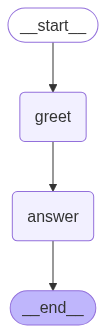

In [10]:
# Visualize the Graph (requires graphviz and pygraphviz or pydot)
display(Image(app.get_graph().draw_mermaid_png()))
# save the graph to a file
with open("output/07-Sequential_Graphs.png", "wb") as f:
    f.write(app.get_graph().draw_mermaid_png())

### 5. Invoke the Graph

In [11]:
initial_state = {
    "name": "Alice",
    "user_question": "What's the capital of France?",
    "messages": []
}
result = app.invoke(initial_state)

/var/folders/m7/yjmck8kn59gc9w3kdklj2lt40000gn/T/ipykernel_35437/927858589.py:5: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  model = ChatOpenAI(model_name="gpt-3.5-turbo")
/var/folders/m7/yjmck8kn59gc9w3kdklj2lt40000gn/T/ipykernel_35437/927858589.py:6: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response: AIMessage = model(history)


### 6. Print Out the Conversation

In [12]:
for msg in result["messages"]:
    msg.pretty_print()

================================== Ai Message ==================================

Hi Alice!
================================ Human Message =================================

What's the capital of France?
================================== Ai Message ==================================

The capital of France is Paris.
